In [89]:
#@@@@@@@@@@@@@@@@@@@@@@@
#import useful libraries
#@@@@@@@@@@@@@@@@@@@@@@@
import pandas as pd
import numpy as np
import copy
from scipy import interpolate
from scipy.stats import truncnorm
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from pydantic import BaseModel
import csv
import os
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Dict
import time

from game import TheGang
from models import HandFeatures

In [90]:
model_name = "Baseline_2"
model_epoch_count = 40000

In [91]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [92]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layer_count = 1):
        super(PolicyNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_layer_size))
        nn.init.normal_(self.hidden_layers[0].weight, mean = 0, std = 0.01)
        nn.init.normal_(self.hidden_layers[0].bias, mean = 0, std = 0.01)
        for _ in range(hidden_layer_count-1):
            layer = nn.Linear(hidden_layer_size, hidden_layer_size)
            self.hidden_layers.append(layer)
            nn.init.normal_(layer.weight, mean = 0, std = 0.01)
            nn.init.normal_(layer.bias, mean = 0, std = 0.01)
        self.output_layer = nn.Linear(hidden_layer_size, 4)    #the output layer with probabiliy for each action
        self.output_layer.bias = nn.Parameter(torch.tensor([0.0, 0.0, 0.0, 0.0])) 

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        '''A function to do the forward pass
            Takes:
                s -- the state representation
            Returns:
                a tensor of probabilities
        '''         
        s = s.to(next(self.parameters()).device)
        for layer in self.hidden_layers:
             s = torch.relu(layer(s))    #pass through the hidden layers
        s = self.output_layer(s)
        action_probs = torch.softmax(s, dim=1)    #use softmax to get action probabilities
        return action_probs.to('cpu')


In [93]:
class AgentConfig(BaseModel):
    hidden_layer_size: int = 32
    hidden_layer_count: int = 8
    learning_rate: float = 0.0005

class Agent():
    def __init__(self, config: AgentConfig):
        self.config = config
        self.pi = PolicyNetwork(17, config.hidden_layer_size, config.hidden_layer_count).to(device)
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.config.learning_rate)

    def generate_actions(self, state_array: List[List[int]]):
        action_probs = self.pi(torch.tensor(state_array, dtype=torch.float32)) # Create tensor and feed state through model
        sampled_actions = torch.multinomial(action_probs, 1).squeeze(dim=1)
        action_space = torch.tensor([1, 2, 3, 4])
        final_actions = action_space[sampled_actions]
        return final_actions

    def generate_actions_with_probs(self, state_array: List[List[int]]):
        action_probs = self.pi(torch.tensor(state_array, dtype=torch.float32)) # Create tensor and feed state through model
        sampled_actions = torch.multinomial(action_probs, 1).squeeze(dim=1)
        action_space = torch.tensor([1, 2, 3, 4])
        final_actions = action_space[sampled_actions]
        return final_actions, action_probs

    def generate_action_probs(self, a: List[int], state_array: List[List[int]]):
        all_action_probs = self.pi(torch.tensor(state_array, dtype=torch.float32)) # Create tensor and feed state through model
        a_tensor = torch.tensor(a, dtype=torch.long)
        a_tensor = a_tensor - 1
        performed_action_probs = all_action_probs.gather(1, a_tensor.unsqueeze(1)).squeeze(1)
        log_probs = torch.log(performed_action_probs)
        return log_probs

    def checkpoint(self, model_name, epoch_count: int):
        directory = f'checkpoints/{model_name}'
        os.makedirs(directory, exist_ok=True)
        torch.save(self.pi.state_dict(), f'{directory}/epi_{epoch_count}.pth')
        
    def load_checkpoint(self, model_name: str, epoch_count: int):
        self.pi.load_state_dict(torch.load(f'checkpoints/{model_name}/epi_{epoch_count}.pth', map_location=device))


In [94]:
agent_config = AgentConfig()
agent = Agent(agent_config)
agent.load_checkpoint(model_name, model_epoch_count)
env = TheGang()

C:\Users\Josh\AppData\Local\Temp\ipykernel_14416\2630794727.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pi.load_state_dict(torch.load(f'checkpoints/{model_name

In [95]:
def simulate_agent(agent: Agent, episodes: int):
    env = TheGang()
    average_episode_rewards = []
    actions = []
    for epi in tqdm(range(episodes)):
        env.reset()

        episode_rewards = []
        episode_states = []
        episode_actions = []
        state = {'state':env.generate_state_array([0,0,0,0]),'reward':[0,0,0,0],'done':False}

        # Loop turns in episode
        while not state['done']:
            episode_states.append(state['state'])

            a = agent.generate_actions(state['state']).tolist()
            actions.append(a)

            episode_actions.append(a)
            state = env.step(a)
            episode_rewards.append(state['reward'])
        average_episode_rewards.append(np.mean(episode_rewards))
    return average_episode_rewards, actions

In [96]:
episode_rewards, actions = simulate_agent(agent, 1000)

100%|██████████| 1000/1000 [00:04<00:00, 237.93it/s]


In [97]:
np.mean(episode_rewards)

34.709375

In [98]:
actions_list = np.array(actions).flatten()

In [99]:
action_space, action_counts = np.unique(actions_list, return_counts=True)

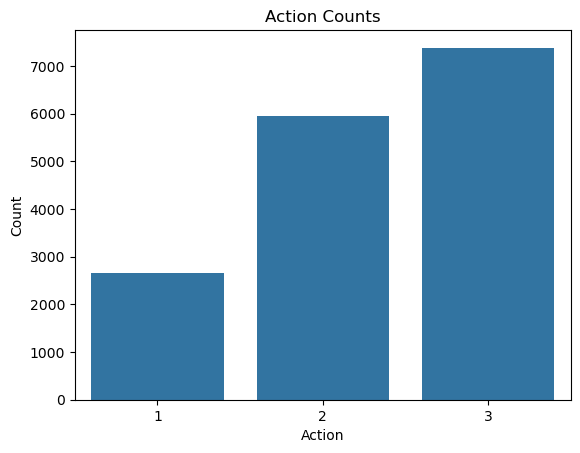

In [100]:
sns.barplot(x=action_space, y=action_counts)
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Counts")
plt.savefig(f"Action_Counts_{model_name}.svg", format="svg")

In [101]:
def simulate_agent(agent: Agent, episodes: int):
    env = TheGang()
    average_episode_rewards = []
    actions = []
    action_probs = []
    for epi in tqdm(range(episodes)):
        env.reset()

        episode_rewards = []
        episode_states = []
        episode_actions = []
        state = {'state':env.generate_state_array([0,0,0,0]),'reward':[0,0,0,0],'done':False}

        # Loop turns in episode
        while not state['done']:
            episode_states.append(state['state'])

            a, probs = agent.generate_actions_with_probs(state['state'])
            a = a.tolist()
            actions.append(a)
            action_probs.append(probs)

            episode_actions.append(a)
            state = env.step(a)
            episode_rewards.append(state['reward'])
        average_episode_rewards.append(np.mean(episode_rewards))
    return average_episode_rewards, actions, action_probs

In [102]:
episode_rewards, actions, action_probs = simulate_agent(agent, 1000)

100%|██████████| 1000/1000 [00:03<00:00, 252.33it/s]


In [103]:
action_probs[1]

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [2.4397e-42, 1.0000e+00, 3.5077e-11, 2.1053e-30],
        [2.7947e-40, 1.0000e+00, 1.8261e-11, 1.4083e-29],
        [0.0000e+00, 8.7691e-10, 1.0000e+00, 0.0000e+00]],
       grad_fn=<SoftmaxBackward0>)

In [104]:
action_probs = [time_step_probs.tolist() for time_step_probs in action_probs]

In [105]:
flat_list = []
for time_step_prob in action_probs:
    flat_list.extend(time_step_prob)

In [106]:
action_probs_df = pd.DataFrame(flat_list, columns=["1", "2", "3", "4"])

In [107]:
action_probs_df.head()

,1,2,3,4
0,4.414090e-43,1.000000,4.438653e-11,1.060798e-30
1,9.988528e-01,0.001147,3.058584e-20,1.796593e-15
2,9.987509e-01,0.001249,3.361213e-20,1.886511e-15
3,0.000000e+00,0.999992,7.859345e-06,0.000000e+00
4,0.000000e+00,0.000000,1.000000e+00,0.000000e+00


C:\Users\Josh\AppData\Local\Temp\ipykernel_14416\2048303853.py:1: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.05`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(action_probs_df, bw=0.05, cut=0)


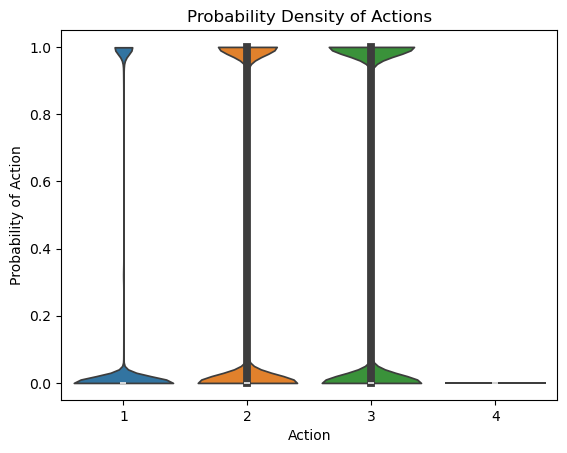

In [108]:
sns.violinplot(action_probs_df, bw=0.05, cut=0)
plt.xlabel("Action")
plt.ylabel("Probability of Action")
plt.title("Probability Density of Actions")
plt.savefig(f"Action_Probability_Density_{model_name}.svg")